### Retrieval-Augmented Generation (RAG) - Basic Method
This notebook demonstrates the initial implementation of RAG with fundamental indexing, retrieval, and generation techniques.
##### Key Highlights:
- **Split documents based on tokens**
  Documents are split based on tokens rather than operating directly on raw characters.
- **Retrieval custom number of chunks using KNN**:  
  The retrieval retrieves the splits that are closer to the prompt embedding using KNN algorithm. The number of such chunks is specified by the author. 
- **Custom Prompt**
  Pre-built Prompts are a great starting point, custom prompt allows to unlock the full potential of LLMs by tailoring the behavior to specific tasks, domains, and user needs.
- **Pipe Chaining**
  Define sequence of operations.

##### What's Next: 


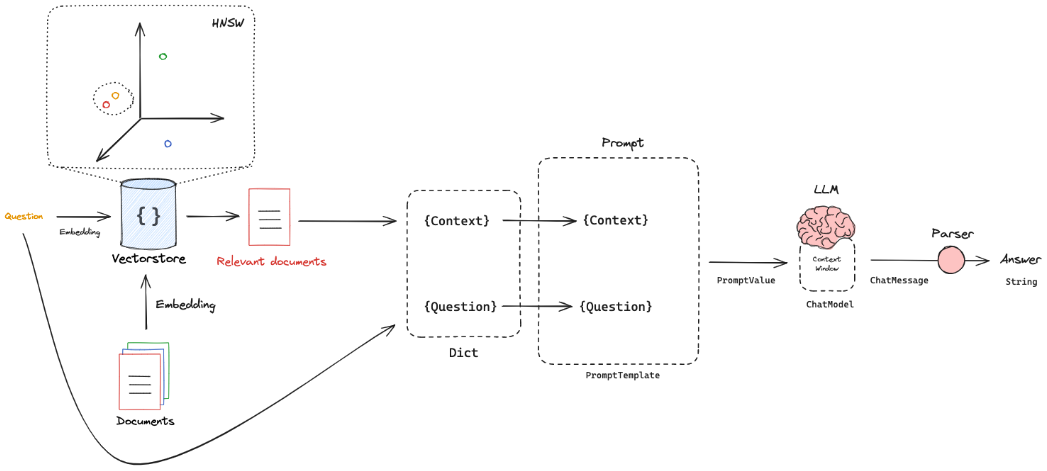

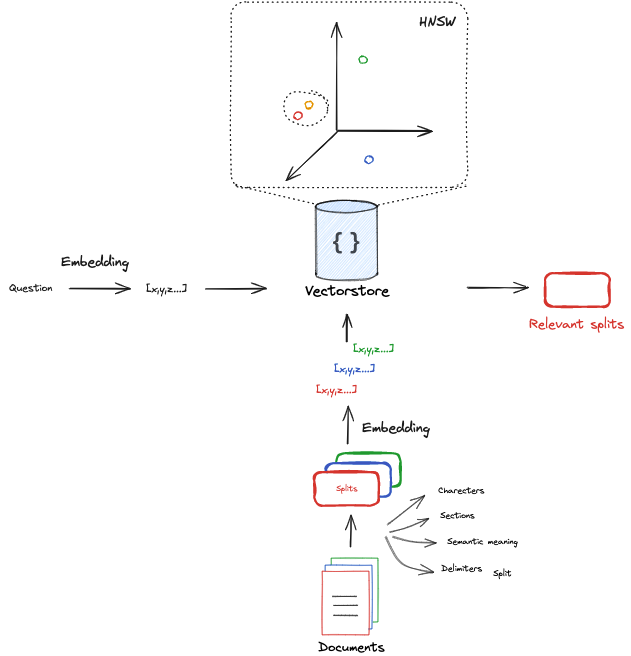

#### Install required libraries

In [39]:
# Install required libraries
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Import required libraries

In [40]:
import os # Operating system relevant tasks
from dotenv import load_dotenv
import bs4 # Import Beautiful Soap, a Python Web Scrapping package
from langchain_community.document_loaders import WebBaseLoader # Load documents from website
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma # Import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain import hub # Python library containing pre-defined Prompts, Chains for LLM applications
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
import numpy as np

#### Environment Setup

In [41]:
# Load environment variables from .env file
load_dotenv()

# API key provides authentication to access LangChain service 
os.environ['LANGCHAIN_TRACING_V2'] = 'true' # Enables LangChain Tracing V2, a mechanism to enable and monitor the execution of LangChain applications for debugging and optimization
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com' # Configures the LangChain API End Point to use LangChain for tracing
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
# API key to access OpenAI services
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

#### Cosine Similarity
Before jumping into the RAG, lets develop a code for the estimating the cosine similarity of two vector embeddings

In [42]:
# Function to calculate the cosine similarity of two vector embeddings
## -1, 0, +1 means opposite, no relation, and identical respectively
def cosine_similarity(emb1, emd2):
    return np.dot(emb1,emd2)/(np.linalg.norm(emb1)*np.linalg.norm(emb1))

In [43]:
# Check for the functioning of cosine similarity
question = "What kinds of pets do I like?"
answer = "My favorite pet is a cat."

# Get the embeddings of question and answer
emb1 = OpenAIEmbeddings().embed_query(question)
emb2 = OpenAIEmbeddings().embed_query(answer)

print(f"Cosine similarity: {round(cosine_similarity(emb1, emb2),2)}")

Cosine similarity: 0.88


#### RAG Process

In [44]:
## Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load() 

## Split the documents based on tokens
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=300, chunk_overlap=50)
splits = text_splitter.split_documents(blog_docs)

## Calculate the vector embeddings of the splits, store in the vector store and convert the vector store into a retriever object
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings()) # Store the vector embeddings of splits in Chroma DB

## Retrieve the documents that are closing matching with prompt using KNN
retriever = vectorstore.as_retriever(search_kwargs={"k": 5}) 

In [45]:
# Check the number of documents retrieved and shall matching with the "k" value
docs = retriever.invoke("What is Task Decomposition?")
len(docs)

5

In [46]:
## Pre-built Prompt
prompt = hub.pull("rlm/rag-prompt") # Fetches RAG specific PROMPT template
print(f"Pre-built Prompt looks like this: {prompt}")

## Custom Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
print(f"Custom Prompt looks like this: {prompt}")


Pre-built Prompt looks like this: input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]
Custom Prompt looks like this: input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the questio

In [47]:
## Define LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

In [48]:
## Create a chain using piping
chain = prompt|llm

# Run
chain.invoke({"context":docs,"question":"What is Task Decomposition?"})

AIMessage(content='Task decomposition is the process of breaking down a complex task into smaller and simpler steps to make it more manageable. It can be done using techniques like Chain of Thought (CoT) or Tree of Thoughts, as well as through simple prompting, task-specific instructions, or human inputs.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 1551, 'total_tokens': 1608, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-70bf4d31-97a1-46e8-bd37-5a473bc8cea7-0', usage_metadata={'input_tokens': 1551, 'output_tokens': 57, 'total_tokens': 1608, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0

#### RAG Chain

In [49]:
# Post-processing - Function to perform post processing on collection documents. Converts list of documents to a single string
## Extract the page content from each document and join the documents into a single string, separating them by '\n\n' for readability
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

#### Invoke LLM 

In [50]:
rag_chain.invoke("What is Task Decomposition?")

'Task Decomposition is a technique used to break down complex tasks into smaller and simpler steps, making them more manageable for an agent to complete. This can be achieved through methods such as Chain of Thought (CoT) or Tree of Thoughts, as well as through simple prompting, task-specific instructions, or human inputs.'

**Few Takeaways:**

Why splitting based on tokens rather that characters?
- Modern language models (e.g., OpenAI, GPT-3/4) process inputs as tokens, not raw characters.
- Token-aware splitting ensures the resulting chunks align with model constraints, such as maximum token limits.

When to use Pre-built and Custom Prompts?
- Tailored to Specific Use Cases: 
    - Pre-built Prompts are often generic and cater to a broad audience.
    - With Custom Prompts, one can design prompts to suit your specific application, domain, or task, improving the relevance and accuracy of responses. 
        - Ex: A legal document summarization tool may require prompts with legal jargon.
- Improve Accuracy of domain specific language:
    - Example:
        - Pre-Built: "Summarize the document."
        - Custom: "Summarize the document focusing on key financial figures and market trends."
- Optimized Performance:
    - By customizing prompts, you can guide the model to focus on what matters most, reducing irrelevant information and improving response efficiency.
        - Example: Custom prompts can specify: "Provide a concise list of bullet points."
- Easier Debugging and Experimentation
    - When using custom prompts, you have complete control, enabling you to tweak and optimize based on performance metrics or user feedback.
- **Best Practices for Custom Prompts:**
    - Test and Iterate: Experiment with different formulations to find the most effective prompt.
    - Use Few-Shot Learning: Provide examples in the prompt to improve results for complex tasks.
    - Stay Concise: Overly long or ambiguous prompts can confuse the model.
    - Embed Context: Dynamically include context when appropriate to enhance relevance.

What is Piping?
- Piping in LangChain refers to the use of the | operator to create a seamless workflow where the output of one component is automatically passed as the input to the next component. 
- Benefits of Piping in LangChain
    - Modularity: Each step is independent and reusable.
    - Readability: The | operator visually represents the flow of data, making the pipeline intuitive.
    - Extensibility: New components can be easily added to the pipeline.
    - Debugging: Each stage of the pipeline can be inspected individually to isolate issues.